# Node Feature Ranking

Taking all nodes from all graphs (across all mu levels), we split nodes into "stable" (entropy < 0.0195) and "unstable" (entropy >= 0.0195) and use a random forest to determine which node features are most important in the associated binary classification task

In [64]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Reading in the data

Node features have been pre-calculated for each node, as have co-assocation matrices for each graph. The node entropies have to be calculated from the co-association matrices 

In [65]:
X_train = pd.read_csv('../lfr_graphs/node_x_train.csv', index_col=0)
y_train = pd.read_csv('../lfr_graphs/node_y_train.csv', index_col=0)

### Feature ranking with random forest

Now we're going to perform the node feature ranking using a random forest. During training, we will use a stratified k-fold cross-validation scheme.

In [66]:
runs = 100

In [67]:
feature_list = list(X_train.columns)
data = np.array(X_train)
labels = np.squeeze(np.array(y_train))

In [84]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracy_scores = []
feature_importances = {}
for f in feature_list:
    feature_importances[f] = []
rows = []

skf = StratifiedKFold(n_splits=5)
rf = RandomForestClassifier()

fold_count = 0

for run in range(1, runs+1):
    
    for i in range(5):
        
        fold_count += 1
        
        folds = next(skf.split(data, labels), None)
        
        X_train_fold = data[folds[0], :]
        X_val_fold = data[folds[1], :]
        y_train_fold = labels[folds[0]]
        y_val_fold = labels[folds[1]]
        
        model = rf.fit(X_train_fold, y_train_fold)
        predictions = rf.predict(X_val_fold)
    
        accuracy_scores.append(metrics.accuracy_score(y_val_fold, predictions))

        row = { "run" : fold_count }
        for j, feature in enumerate(feature_list):
            row[feature] = rf.feature_importances_[j]
        rows.append(row)

### Check accuracy scores

Let's have a look at the accuracy scores to make sure the model is working.

In [85]:
print(accuracy_scores)
print('~~~~~~~~~~~~~~~~~~~~~')
print(np.mean(accuracy_scores))

[0.8953125, 0.89375, 0.90625, 0.90625, 0.9015625, 0.8921875, 0.8984375, 0.9, 0.9046875, 0.8984375, 0.903125, 0.9046875, 0.9046875, 0.8984375, 0.896875, 0.903125, 0.9046875, 0.8953125, 0.90625, 0.903125, 0.9, 0.9, 0.9015625, 0.903125, 0.896875, 0.9078125, 0.896875, 0.8984375, 0.896875, 0.909375, 0.909375, 0.8984375, 0.90625, 0.9, 0.9015625, 0.9015625, 0.9078125, 0.903125, 0.896875, 0.903125, 0.90625, 0.9125, 0.90625, 0.903125, 0.9, 0.903125, 0.9078125, 0.9046875, 0.9, 0.9015625, 0.9078125, 0.903125, 0.9109375, 0.9046875, 0.9015625, 0.90625, 0.909375, 0.903125, 0.9046875, 0.9015625, 0.903125, 0.903125, 0.909375, 0.9046875, 0.909375, 0.90625, 0.9, 0.90625, 0.896875, 0.9, 0.9046875, 0.903125, 0.9, 0.9015625, 0.9, 0.90625, 0.903125, 0.8984375, 0.8921875, 0.9078125, 0.9015625, 0.9078125, 0.9078125, 0.9015625, 0.903125, 0.9078125, 0.903125, 0.890625, 0.9015625, 0.896875, 0.896875, 0.903125, 0.9015625, 0.903125, 0.90625, 0.8953125, 0.909375, 0.909375, 0.903125, 0.903125, 0.9046875, 0.9015625, 

### Feature ranking

From the accuracy scores, we can see that the model is definitely learning something, so now let's rank the features.

In [86]:
df_importances = pd.DataFrame(rows).set_index("run")

In [87]:
feature_ranking = df_importances.mean().sort_values(ascending=False)

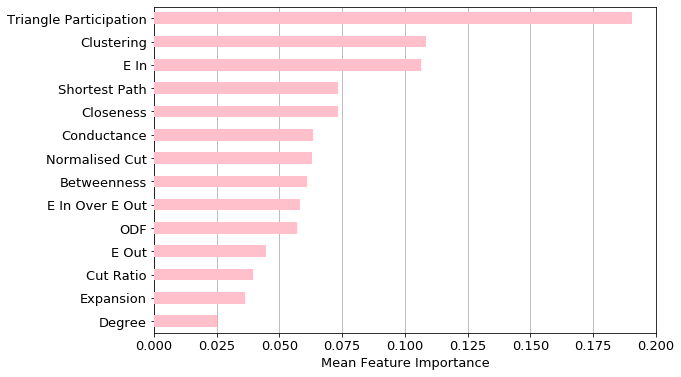

In [88]:
ax = feature_ranking[::-1].plot.barh( fontsize=13, figsize=(9,6), color="pink", zorder=3 );
ax.set_xlabel("Mean Feature Importance", fontsize=13);
ax.xaxis.grid();

### Pairwise graph training

Now we're going to train and validate the model using the method suggested by Derek (train on 1 graph, validate on another, then swap). We're still using the same train set of nodes previously created. As the train set did not at all depend on graph, each graph has a random number of nodes for training. We can check that these are at least roughly equal when we segregate by graph. Unfortunately graph segregation has to be done by reading strings as this is the only place I saved the graph information in the train set.

In [94]:
train_indices_by_graph = {(i,j): [] for i in [1,2,3,4] for j in [1,2,3,4,5]}

In [95]:
for graph_string in list(X_train.index):
    mu_val = int(graph_string[6])
    graph_val = int(graph_string[8])
    train_indices_by_graph[(mu_val, graph_val)].append(graph_string)

In [96]:
print([len(l) for l in train_indices_by_graph.values()])

[162, 157, 154, 161, 158, 158, 159, 158, 157, 162, 153, 172, 162, 159, 169, 158, 164, 152, 163, 162]


All our train/validation sets here are roughly the same size (152-172).

In [97]:
runs = 100

In [98]:
feature_list = list(X_train.columns)

data = []
labels = []
for _, graph_indices in train_indices_by_graph.items():
    data.append(np.array(X_train.loc[graph_indices]))
    labels.append(np.squeeze(np.array(y_train.loc[graph_indices])))

Create the set of pairs of graphs to train on.

In [102]:
graph_pairs = [(i,j) for i in range(20) for j in range(20) if i < j]

In [106]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracy_scores = []
feature_importances = {}
for f in feature_list:
    feature_importances[f] = []
rows = []

skf = StratifiedKFold(n_splits=5)
rf = RandomForestClassifier()

for graph_1, graph_2 in graph_pairs:
    
    X_graph_1 = data[graph_1]
    X_graph_2 = data[graph_2]
    y_graph_1 = labels[graph_1]
    y_graph_2 = labels[graph_2]

    model = rf.fit(X_graph_1, y_graph_1)
    predictions = rf.predict(X_graph_2)

    accuracy_scores.append(metrics.accuracy_score(y_graph_2, predictions))
    
    model = rf.fit(X_graph_2, y_graph_2)
    predictions = rf.predict(X_graph_1)

    accuracy_scores.append(metrics.accuracy_score(y_graph_1, predictions))

    row = { "run" : run }
    for i, feature in enumerate(feature_list):
        row[feature] = rf.feature_importances_[i]
    rows.append(row)

In [110]:
print(accuracy_scores)
print('~~~~~~~~~~~~~~~~~~~~~')
print(np.mean(accuracy_scores))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9810126582278481, 1.0, 0.9937106918238994, 1.0, 0.9746835443037974, 1.0, 1.0, 1.0, 0.9567901234567902, 1.0, 0.6470588235294118, 0.9938271604938271, 0.8895348837209303, 1.0, 0.8209876543209876, 1.0, 0.7232704402515723, 0.018518518518518517, 0.9940828402366864, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9810126582278481, 1.0, 0.9937106918238994, 1.0, 0.9746835443037974, 1.0, 1.0, 1.0, 0.9567901234567902, 1.0, 0.6470588235294118, 0.9681528662420382, 0.8895348837209303, 1.0, 0.8209876543209876, 1.0, 0.7232704402515723, 0.9808917197452229, 0.9940828402366864, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.9810126582278481, 1.0, 0.9937106918238994, 1.0, 0.9746835443037974, 1.0, 1.0, 1.0, 0.9567901234567902, 1.0, 0.6470588235294118, 0.9805194805194806, 0.8895348837209303, 1.0, 0.8209876543209876, 1.0, 0.7232704402515723, 0.9805194805194806, 0.9940828402366864, 1.0, 0.0, 0.0, 0.

In [107]:
df_importances = pd.DataFrame(rows).set_index("run")

In [108]:
feature_ranking = df_importances.mean().sort_values(ascending=False)

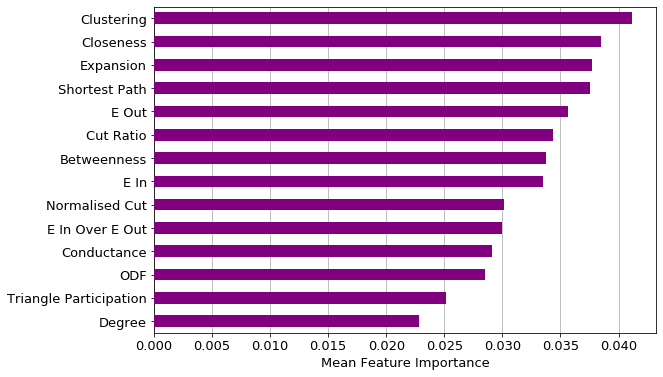

In [109]:
ax = feature_ranking[::-1].plot.barh( fontsize=13, figsize=(9,6), color="purple", zorder=3 );
ax.set_xlabel("Mean Feature Importance", fontsize=13);
ax.xaxis.grid();